<a href="https://colab.research.google.com/github/arny617/MLNanodegree/blob/master/CreditSpreadPrediction_UsingLowRankModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from scipy import stats
%matplotlib inline

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/Colab Notebooks/"
os.chdir(ROOT)

Mounted at /content/gdrive


In [ ]:
!pip install h2o

     |████████████████████████████████| 164.6MB 82kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=ef0c7f8a6417d01aad28c8f3b2e3691e5447eb7fe17acb8d8e1ccdcd6cf67c48
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [ ]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv9ajfdd4
  JVM stdout: /tmp/tmpv9ajfdd4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv9ajfdd4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,"28 days, 10 hours and 14 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_t31i0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


### Load Data

In [ ]:
df_tot = pd.read_csv('iaqf_data.csv',index_col=0)
df_tot.index = pd.to_datetime(df_tot.index)

non_daily_input_list = ['STLFSI', 'TB3MS', 'WM2NS', 'WM1NS', 'USROE', 'UNRATE', 'TOTLL', 'TOTCI',
                             'TOTBKCR','TERMCBAUTO48NS','RECPROUSM156N','PSAVERT','PCE','PAYNSA','INDPRO',
                             'CPIAUCSL','CSUSHPINSA','GDP','Bill_Gross_Issues','Bill_Net','Notes_Gross_Issues',
                             'Notes_Net','Bonds_Gross_Issues','Bonds_Net','TOTAL_Gross_Issues','Total_Net_Cash Raised',
                             '10-year issuance','Investment Grade','High Yield','Total','Economic Policy Uncertainty',
                        'Monetary policy','Fiscal Policy',
                        'Health care','National security','Entitlement programs','Regulation','Financial Regulation',
                        'Trade policy','Sovereign debt']

In [ ]:
from scipy.stats import kurtosis,skew,norm
def normFitPlot(dataset):
    dataset = np.squeeze(dataset)
    sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20}) 
    sns.distplot(dataset , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(dataset)
    kur = kurtosis(dataset)
    sk = skew(dataset)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    print( '\n kurtosis = {:.2f} and skew = {:.2f}\n'.format(kur, sk))

    #Now plot the distribution
    plt.legend(['Distribution $\mu=$ {:.2f} and $\sigma=$ {:.2f} \n kurtosis = {:.2f} and skew = {:.2f}\n'.format(mu, sigma,kur,sk)],
                loc='best',fontsize=10)
    plt.ylabel('Frequency',fontsize=20)
    plt.title('Target distribution',fontsize=30)

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(dataset, plot=plt)
    plt.show()

In [ ]:
non_daily_column = non_daily_input_list
daily_column = df_tot.columns.difference(non_daily_column)

In [ ]:
df_tot_nondaily = df_tot[non_daily_column]
df_tot_daily = df_tot[daily_column]

In [ ]:
# Delete data on non-trading date
df_tot_daily = df_tot_daily[~df_tot_daily.SPY_High.isnull()]
df_tot_daily = df_tot_daily[~df_tot_daily.DGS10.isnull()]
df_tot_daily = df_tot_daily[~df_tot_daily.BAMLC0A1CAAAEY.isnull()]

In [ ]:
df_tot_daily.isnull().sum()[df_tot_daily.isnull().sum()>0].sort_values(ascending = True).head()

^VIX_ROC    1
SPY_TR      1
DPRIME      1
SPY_ROC     1
^VIX_TR     1
dtype: int64

In [ ]:
# Simply use a forward fill for other missing data
for i in df_tot_daily:
    df_tot_daily[i] = df_tot_daily[i].fillna(method = 'ffill')


In [ ]:
df_tot = df_tot_daily.copy(deep=True)
feature_col = df_tot.columns.difference(['AAA10Y'])

In [ ]:
# Transform our features which are skewed
skewed_feats = df_tot[feature_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewDF = pd.DataFrame({'Skew' :skewed_feats})
skewDF.head()

,Skew
^VIX_bl,65.095892
meltdown,14.353858
investment-grade,8.330854
bond broker,7.442682
sell-off,6.761579


In [ ]:
skewness = skewDF
skewness = skewness.dropna()
print("There are {} skewed features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0
df_tot_log = df_tot.copy()
for feat in skewed_features:
    df_tot_log[feat] = np.log(np.abs(df_tot[feat])+1)*np.sign(df_tot[feat])
print("Transform Finished!")

There are 120 skewed features to Box Cox transform
Transform Finished!


In [ ]:
skewed_feats = df_tot_log.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewDF = pd.DataFrame({'Skew' :skewed_feats})
skewDF.head()

,Skew
investment-grade,7.104952
^VIX_bl,6.629973
bond broker,5.482865
sell-off,3.747732
TEDRATE,2.253001


In [ ]:
from statsmodels.tsa.stattools import adfuller
pvalue_dic_daily = {}
stationary_daily = []
non_stationary_daily = []
for i in daily_column.difference(['AAA10Y']):
    cur = df_tot_log[i].dropna()
    p = adfuller(cur)[1]
    pvalue_dic_daily[i] = p
    if p > 0.05:
        non_stationary_daily.append(i)
    else:
        stationary_daily.append(i)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [ ]:
df_tot_station = df_tot_station[~df_tot_station.SPY_High.isnull()]
df_tot_station = df_tot_station[~df_tot_station.DGS10.isnull()]
df_tot_station = df_tot_station[~df_tot_station.BAMLC0A1CAAAEY.isnull()]

In [ ]:
for i in df_tot_station.columns:
    df_tot_station[i] = df_tot_station[i].fillna(method='ffill')
df_tot_station.dropna(inplace=True)

In [ ]:
y = df_tot_station['AAA10Y'].shift(-1)
X = df_tot_station.drop(['AAA10Y'],axis = 1)

In [ ]:
X['y_lag1'] = df_tot_station['AAA10Y']

In [ ]:
d_daily = {}
stationary_daily = stationary_daily+['AAA10Y']
df_tot_station = df_tot_log[stationary_daily]
for i in non_stationary_daily:
    cur = df_tot_log[i].dropna()
    p = adfuller(cur)[1]
    j = 0
    while p >= 0.05:
        cur = cur.diff(1).fillna(0)
        p = adfuller(cur)[1]
        j = j+1
    df_tot_station = df_tot_station.join(cur,how='outer')
    d_daily[i] = j

In [ ]:
X = X[:-1]
y = y[:-1]
y.name = 'Credit Spread'

In [ ]:
!pip install hmmlearn

In [ ]:
from hmmlearn.hmm import GaussianHMM
remodel1 = GaussianHMM(n_components=3, covariance_type="full", n_iter=5000,algorithm='map')
remodel1.fit(np.array(y).reshape(-1,1))
Z2 = remodel1.predict(np.array(y).reshape(-1,1))

In [ ]:
X['market regime_cs'] = pd.DataFrame(Z2,index=X.index).astype('category')

Text(0, 0.5, 'credit spread')

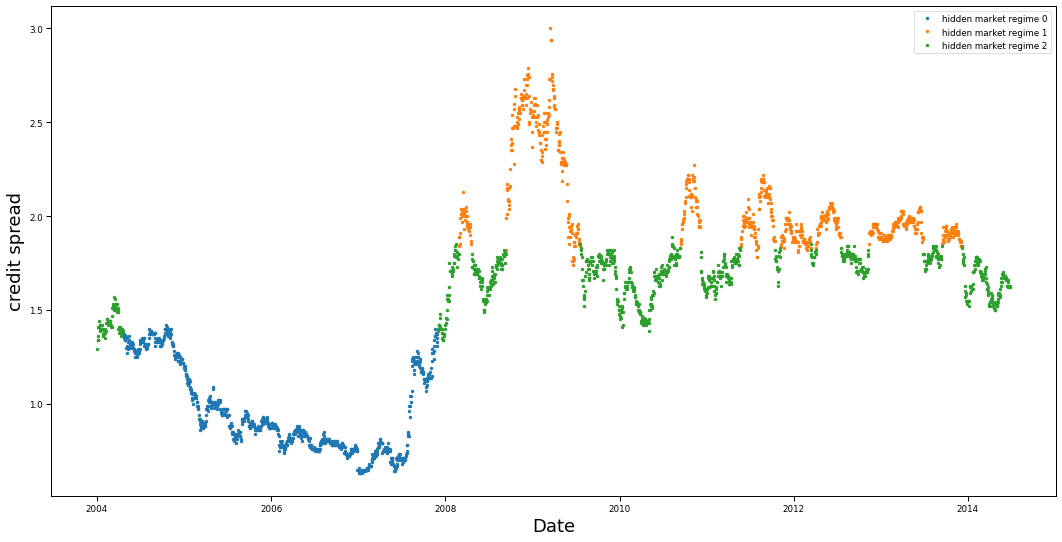

In [ ]:
# take a look at the dataset
plt.figure(figsize = (18,9))
for i in range(remodel1.n_components):
    pos = (X_train['market regime_cs'] == i)
    plt.plot(X_train.index[pos],y_train[pos],'.',label='hidden market regime {}'.format(i),lw=1)
plt.legend(loc='best')
plt.xlabel('Date',fontsize=18)
plt.ylabel('credit spread',fontsize=18)

### GLRM: H2o Model

In [ ]:
y.head()

date
2004-01-02    1.29
2004-01-05    1.34
2004-01-06    1.34
2004-01-07    1.36
2004-01-08    1.41
Name: Credit Spread, dtype: float64

In [ ]:
df_GLRM = pd.merge(X,y,left_index=True,right_index=True)

In [ ]:
df_GLRM[['credit spread','Credit Spread','y_lag1']]

,credit spread,Credit Spread,y_lag1
date,,,
2004-01-02,0.000000,1.29,1.35
2004-01-05,0.000000,1.34,1.29
2004-01-06,0.000000,1.34,1.34
2004-01-07,0.000000,1.36,1.34
2004-01-08,0.000000,1.41,1.36
...,...,...,...
2018-12-21,0.211309,1.22,1.18
2018-12-24,0.200671,1.20,1.22
2018-12-26,-0.537143,1.24,1.20


In [ ]:
arrestsH2O = h2o.H2OFrame(df_GLRM)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
type(arrestsH2O.columns)

list

In [ ]:
def preprocess(df,split_date):
  df_h2o = df.copy(deep=True)
  df_h2o[df_h2o.index >=split_date]['y_lag1'] = None
  df_h2o[df_h2o.index >=split_date]['Credit Spread'] = None
  return df_h2o

### GLRM Function
def glrm(df_h2o,split_date,d_interest_cpy,k=8,loss="Huber"):
    ### Split into training and test
    #train = df_h2o[df_h2o.index <split_date]
    #test  = df_h2o[df_h2o.index >= split_date]
    ## Build glrm model
    glrm_model = H2OGeneralizedLowRankEstimator(k=k,
                                            loss=loss,
                                            regularization_x = 'L2',
                                            regularization_y = 'L2',
                                            #loss_by_col=loss,
                                            gamma_x=0.3,
                                            gamma_y=0.3,
                                            max_iterations=1000,
                                            recover_svd=True,
                                            init="SVD",
                                           )
    glrm_model.train(training_frame=df_h2o)
    glrm_model.model_performance(df_h2o)
    d_interest_predict = glrm_model.predict(df_h2o).as_data_frame()
    d_interest_predict.set_index(d_interest_cpy.index,inplace=True)
    plot_fn(d_interest_cpy,d_interest_predict,split_date)
    return d_interest_predict
def glrm_model(df,split_date,k=8,loss="Huber"):
    df_h2o = preprocess(df,split_date)
    arrestsH2O = h2o.H2OFrame(df_h2o)
    
    return glrm(arrestsH2O,split_date,df,k,loss)   

def plot_fn(df_glrm,df_glrm_pred,split_date):
    fig = plt.figure(figsize=(7,7))
    df_glrm_pred.loc[df_glrm_pred.index>=split_date]['reconstr_Credit Spread'].plot(label='Predict Spreads')
    df_glrm.loc[df_glrm.index>=split_date]['Credit Spread'].plot(label='Actual')
    plt.legend()
    plt.show()

In [ ]:
split_date = datetime(2016,10,1)
df_glrm_predict = glrm_model(df_GLRM,split_date,k=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Parse progress: |█████████████████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [^VIX_Volume]
  warnings.warn(mesg["message"], RuntimeWarning)


glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


In [ ]:
select_cols = ['BDSpread_long', 'BDSpread_short', 'M6M3', 'SPY_DIFF', 'SPY_bl',
       'SPY_bu', 'TEDRATE', 'Y1M6', '^VIX_DIFF', '^VIX_TR', 'crisis',
       'leverage', 'risk', 'USD1MTD156N', 'bidder', 'buy bond', 'credit cycle',
       'debt fund', 'interest expense', 'y_lag1', 'market regime_cs','Credit Spread']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


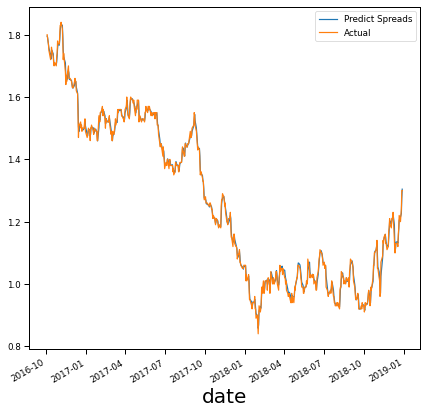

In [ ]:
df_glrm_predict = glrm_model(df_GLRM[select_cols],split_date,k=14,loss="Huber")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


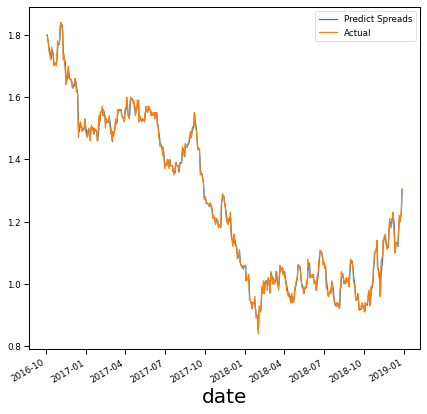

In [ ]:
df_glrm_predict2 = glrm_model(df_GLRM[select_cols],split_date,k=14,loss="Absolute")